In [1]:
import re
import os
import time
import random
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from os import system
from math import floor
from copy import deepcopy
from rake_nltk import Rake

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from surprise import Reader, Dataset, SVD

In [3]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Collect Data from Tables

In [247]:
# data from 1999 - 2009
df = pd.read_csv('goodreads_data_quan1.csv')
df.drop(index=1899,inplace=True) # book with unclean data

# data from 2009 - 2019
df1 = pd.read_csv('goodread_data2_reb1.csv')


# combine the dataframes
dff = pd.concat([df,df1])
dff.reset_index(inplace=True)
dff.drop(['Unnamed: 0','format', 'index'],axis=1,inplace=True)
dff.dropna(inplace=True)

In [252]:
# clean dataframe

# str -> float
dff.ratings = dff.ratings.apply(lambda x: float(x))
dff.num_ratings = dff.num_ratings.apply(lambda x: int(x.replace(' ratings','').replace(',','')))
dff.pages = dff.pages.apply(lambda x: int(x.replace(' pages','')))

dff.dropna(inplace=True)

# clean up genre (as a string)
dff.genre = dff.genre.apply(lambda x: x.replace('{','').replace('}',''))
dff.genre = dff.genre.apply(lambda x: x.replace("'",''))

# NLP Cleaning

In [10]:
# NLP imports
import nltk
from nltk.corpus import gutenberg, stopwords
from nltk.collocations import *
from nltk import FreqDist
from nltk import word_tokenize
import string
import re

In [11]:
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
stopwords_list = stopwords.words('english')
stopwords_list += list(string.punctuation)
stopwords_list += ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
stopwords_list += ['book', 'author', 'novel', 'year', 'come', 'stories','story','thing']

In [12]:
nlp = dff[['description']]
nlp['describe_raw'] = nlp.description.apply(lambda info: nltk.regexp_tokenize(info, pattern));
nlp['describe_tokens'] = nlp.describe_raw.apply(lambda x: [word.lower() for word in x]);
nlp['words_stopped'] = nlp.describe_tokens.apply(lambda x : [word for word in x if word not in stopwords_list]);
nlp['freq_dist'] = nlp.words_stopped.apply(lambda x: FreqDist(x));
nlp['freq_dist_top'] = nlp.freq_dist.apply(lambda x: x.most_common(20));

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

In [13]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

In [14]:
stemmer = SnowballStemmer("english")
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text) :
        if token not in gensim.parsing.preprocessing.STOPWORDS and token not in stopwords_list and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [15]:
nlp['prepro_des'] = nlp.description.apply(lambda x: preprocess(x))

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [16]:
preprocess_des = nlp['prepro_des']

In [222]:
df_filter

,bag_of_words,num_ratings,pages,ratings
titles,,,,
"Harry Potter and the Prisoner of Azkaban (Harry Potter, #3)",jkrowling middlegrade adventure fantasy audiob...,2435849,435.000,4.560
The Perks of Being a Wallflower,stephenchbosky fiction contemporary youngadult...,1138861,224.000,4.200
A Walk to Remember,nicholassparks romance chicklit contemporary f...,617830,215.000,4.170
"The Bad Beginning (A Series of Unfortunate Events, #1)",lemonysnicket youngadult childrens fantasy fic...,357436,176.000,3.930
Interpreter of Maladies,jhumpalahiri shortstories cultural fiction ind...,149557,198.000,4.140
"The Reptile Room (A Series of Unfortunate Events, #2)",lemonysnicket youngadult childrens fantasy fic...,167958,192.000,3.980
Timeline,michaelcrichton historicalfiction thriller sci...,177986,489.000,3.850
"Ender's Shadow (The Shadow Series, #1)",orsonscottcard youngadult sciencefiction ficti...,143282,469.000,4.310
Invisible Monsters,chuckpalahniuk mystery contemporary thriller f...,117223,304.000,4.000


In [224]:
l = ['a','b','c']
' , '.join(l)

'a , b , c'

In [225]:
dff[dff['authors'] == 'rupikaur']

,index,authors,description,genre,id,num_ratings,pages,ratings,titles,Key_words,bag_of_words
2998,2998,rupikaur,Milk and honey is a collection of poetry and p...,"[feminism, poetry, nonfiction]",23513349,265126,204.000,4.110,Milk and Honey,"[sweetness, everywhere, violence, abuse, love,...",rupikaur feminism poetry nonfiction sweetness ...
3609,3609,rupikaur,From Rupi Kaur the New York Times bestselling...,"[feminism, poetry, nonfiction]",35606560,96691,256.000,4.170,The Sun and Her Flowers,"[honey, comes, illustrated, love, recipe, poet...",rupikaur feminism poetry nonfiction honey come...


In [221]:
dff.head()

,index,authors,description,genre,id,num_ratings,pages,ratings,titles,Key_words,bag_of_words
0,0,jkrowling,Harry Potters third year at Hogwarts is full o...,"[middlegrade, adventure, fantasy, audiobook, c...",5,2435849,435.000,4.560,Harry Potter and the Prisoner of Azkaban (Harr...,"[hunting, sirius, father, yet, despite, threat...",jkrowling middlegrade adventure fantasy audiob...
1,1,stephenchbosky,Now in a special edition to mark the twentieth...,"[fiction, contemporary, youngadult]",47440429,1138861,224.000,4.200,The Perks of Being a Wallflower,"[high, school, funny, touching, beloved, cult,...",stephenchbosky fiction contemporary youngadult...
2,2,nicholassparks,There was a time when the world was sweeterwhe...,"[romance, chicklit, contemporary, fiction, you...",35545737,617830,215.000,4.170,A Walk to Remember,"[leading, author, bottle, beaufort, north, car...",nicholassparks romance chicklit contemporary f...
3,3,lemonysnicket,Dear Reader Im sorry to say that the book you...,"[youngadult, childrens, fantasy, fiction]",78411,357436,176.000,3.930,The Bad Beginning (A Series of Unfortunate Eve...,"[unpleasant, tales, putting, say, clever, sort...",lemonysnicket youngadult childrens fantasy fic...
4,4,jhumpalahiri,Navigating between the Indian traditions theyv...,"[shortstories, cultural, fiction, india]",5439,149557,198.000,4.140,Interpreter of Maladies,"[generations, ancestors, navigating, interpret...",jhumpalahiri shortstories cultural fiction ind...


In [17]:
dictionary = gensim.corpora.Dictionary(preprocess_des)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 ach
1 adventur
2 art
3 await
4 azkaban
5 belov
6 best
7 black
8 break
9 broom
10 catch


In [18]:
dictionary.filter_extremes(no_below=20, no_above=0.66, keep_n=10000)


In [19]:
len(dictionary)

2466

In [20]:
bow_corpus = [dictionary.doc2bow(doc) for doc in preprocess_des]
bow_corpus[0]

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 2),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 1),
 (13, 1),
 (14, 1),
 (15, 1),
 (16, 1),
 (17, 1),
 (18, 1),
 (19, 1),
 (20, 1),
 (21, 1),
 (22, 1),
 (23, 1),
 (24, 1),
 (25, 1),
 (26, 1),
 (27, 1),
 (28, 1),
 (29, 1),
 (30, 5),
 (31, 1),
 (32, 1),
 (33, 1),
 (34, 1),
 (35, 1),
 (36, 1),
 (37, 2),
 (38, 1),
 (39, 1),
 (40, 1),
 (41, 1),
 (42, 1),
 (43, 1),
 (44, 1),
 (45, 1),
 (46, 1),
 (47, 1),
 (48, 1),
 (49, 1),
 (50, 1),
 (51, 1),
 (52, 1),
 (53, 1),
 (54, 1),
 (55, 1),
 (56, 1),
 (57, 1),
 (58, 1),
 (59, 1),
 (60, 1),
 (61, 1),
 (62, 1),
 (63, 1),
 (64, 2),
 (65, 1)]

In [21]:
bow_doc_0 = bow_corpus[0]
for i in range(len(bow_doc_0)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_0[i][0], 
                                               dictionary[bow_doc_0[i][0]], 
bow_doc_0[i][1]))

Word 0 ("ach") appears 1 time.
Word 1 ("adventur") appears 1 time.
Word 2 ("art") appears 1 time.
Word 3 ("await") appears 1 time.
Word 4 ("belov") appears 1 time.
Word 5 ("best") appears 1 time.
Word 6 ("black") appears 2 time.
Word 7 ("break") appears 1 time.
Word 8 ("catch") appears 1 time.
Word 9 ("childhood") appears 1 time.
Word 10 ("close") appears 1 time.
Word 11 ("closer") appears 1 time.
Word 12 ("continu") appears 1 time.
Word 13 ("convict") appears 1 time.
Word 14 ("cute") appears 1 time.
Word 15 ("danger") appears 1 time.
Word 16 ("dark") appears 1 time.
Word 17 ("defens") appears 1 time.
Word 18 ("despair") appears 1 time.
Word 19 ("despit") appears 1 time.
Word 20 ("educ") appears 1 time.
Word 21 ("effort") appears 1 time.
Word 22 ("evil") appears 1 time.
Word 23 ("father") appears 1 time.
Word 24 ("fourth") appears 1 time.
Word 25 ("friend") appears 1 time.
Word 26 ("frighten") appears 1 time.
Word 27 ("funni") appears 1 time.
Word 28 ("grow") appears 1 time.
Word 29 ("

## TF-IDF

In [22]:
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.13788066590059778),
 (1, 0.08034643660007196),
 (2, 0.13367712067073523),
 (3, 0.11053581387639434),
 (4, 0.08874767722265887),
 (5, 0.055784638422334484),
 (6, 0.1690093548013667),
 (7, 0.06706086861736571),
 (8, 0.08533154266578252),
 (9, 0.09227671801495374),
 (10, 0.07842257270608229),
 (11, 0.10279359967581424),
 (12, 0.09451191280578862),
 (13, 0.12176311213171508),
 (14, 0.13975545328988404),
 (15, 0.05739431700795589),
 (16, 0.05755005919171883),
 (17, 0.1274042447681287),
 (18, 0.1255899770841674),
 (19, 0.0965207237732077),
 (20, 0.12075902710070109),
 (21, 0.11579859097274402),
 (22, 0.08561265893109299),
 (23, 0.0608025998298012),
 (24, 0.1361231316208895),
 (25, 0.046325935392080554),
 (26, 0.12075902710070109),
 (27, 0.0941268192184464),
 (28, 0.0669152134092989),
 (29, 0.10610464479342294),
 (30, 0.5411650475670166),
 (31, 0.1267863870997809),
 (32, 0.06415019597617896),
 (33, 0.09122241724252456),
 (34, 0.07217158189003528),
 (35, 0.12333986513072936),
 (36, 0.05

In [23]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=20, id2word=dictionary, passes=4, workers=2)

In [24]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.014*"time" + 0.012*"life" + 0.010*"love" + 0.007*"world" + 0.006*"live" + 0.006*"famili" + 0.006*"york" + 0.006*"bestsel" + 0.005*"reader" + 0.004*"friend"
Topic: 1 
Words: 0.012*"friend" + 0.009*"magic" + 0.009*"queen" + 0.008*"king" + 0.006*"girl" + 0.006*"life" + 0.006*"time" + 0.006*"young" + 0.006*"edit" + 0.006*"world"
Topic: 2 
Words: 0.014*"world" + 0.014*"time" + 0.010*"human" + 0.009*"life" + 0.008*"year" + 0.007*"live" + 0.006*"work" + 0.006*"write" + 0.006*"woman" + 0.006*"father"
Topic: 3 
Words: 0.017*"vampir" + 0.013*"power" + 0.008*"world" + 0.008*"life" + 0.008*"dark" + 0.007*"human" + 0.007*"battl" + 0.007*"dead" + 0.007*"know" + 0.006*"surviv"
Topic: 4 
Words: 0.018*"love" + 0.014*"past" + 0.010*"life" + 0.009*"power" + 0.008*"famili" + 0.007*"bestsel" + 0.007*"york" + 0.006*"danger" + 0.006*"destroy" + 0.006*"time"
Topic: 5 
Words: 0.011*"world" + 0.007*"time" + 0.007*"work" + 0.006*"life" + 0.006*"know" + 0.006*"power" + 0.005*"young" + 0.005*"be

In [25]:
# !pip install pyLDAvis

In [26]:
#tfidf
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=20, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.003*"love" + 0.003*"life" + 0.003*"dark" + 0.002*"year" + 0.002*"world" + 0.002*"work" + 0.002*"know" + 0.002*"mother" + 0.002*"time" + 0.002*"famili"
Topic: 1 Word: 0.004*"alic" + 0.004*"want" + 0.003*"life" + 0.003*"know" + 0.003*"harri" + 0.003*"love" + 0.003*"school" + 0.003*"live" + 0.003*"famili" + 0.003*"world"
Topic: 2 Word: 0.004*"vampir" + 0.003*"friend" + 0.003*"love" + 0.003*"girl" + 0.003*"famili" + 0.003*"young" + 0.003*"world" + 0.002*"life" + 0.002*"live" + 0.002*"know"
Topic: 3 Word: 0.003*"world" + 0.003*"life" + 0.003*"love" + 0.003*"girl" + 0.003*"time" + 0.002*"friend" + 0.002*"secret" + 0.002*"dead" + 0.002*"forc" + 0.002*"human"
Topic: 4 Word: 0.003*"love" + 0.003*"live" + 0.003*"world" + 0.003*"life" + 0.002*"leav" + 0.002*"secret" + 0.002*"know" + 0.002*"year" + 0.002*"friend" + 0.002*"power"
Topic: 5 Word: 0.003*"love" + 0.003*"time" + 0.003*"life" + 0.003*"power" + 0.002*"peopl" + 0.002*"human" + 0.002*"live" + 0.002*"begin" + 0.002*"world" +

Topic Modeling: 

In [39]:
# dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
# corpus = pickle.load(open('corpus.pkl', 'rb'))
# lda = gensim.models.ldamodel.LdaModel.load('model5.gensim')
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(lda_model_tfidf, corpus_tfidf, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

//anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [27]:
for index, score in sorted(lda_model_tfidf[bow_corpus[1000]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))


Score: 0.521354615688324	 
Topic: 0.003*"love" + 0.003*"friend" + 0.003*"life" + 0.003*"know" + 0.003*"secret" + 0.003*"like" + 0.002*"famili" + 0.002*"live" + 0.002*"world" + 0.002*"time"

Score: 0.37737342715263367	 
Topic: 0.004*"alic" + 0.004*"want" + 0.003*"life" + 0.003*"know" + 0.003*"harri" + 0.003*"love" + 0.003*"school" + 0.003*"live" + 0.003*"famili" + 0.003*"world"

Score: 0.09036842733621597	 
Topic: 0.003*"reacher" + 0.003*"girl" + 0.003*"world" + 0.003*"famili" + 0.003*"father" + 0.002*"dark" + 0.002*"time" + 0.002*"secret" + 0.002*"mother" + 0.002*"love"


# EDA


In [75]:
df

,titles,authors,ratings,num_ratings,id,description,pages,genre
0,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling,4.560,2435849,5,Harry Potter's third year at Hogwarts is full ...,435.000,"'Middle Grade', 'Adventure', 'Fantasy', 'Audio..."
1,The Perks of Being a Wallflower,Stephen Chbosky,4.200,1138861,47440429,Now in a special edition to mark the twentieth...,224.000,"'Fiction', 'Contemporary', 'Young Adult'"
2,A Walk to Remember,Nicholas Sparks,4.170,617830,35545737,There was a time when the world was sweeter......,215.000,"'Romance', 'Chick Lit', 'Contemporary', 'Ficti..."
3,The Bad Beginning (A Series of Unfortunate Eve...,Lemony Snicket,3.930,357436,78411,"Dear Reader, I'm sorry to say that the book y...",176.000,"'Young Adult', 'Childrens', 'Fantasy', 'Fiction'"
4,Interpreter of Maladies,Jhumpa Lahiri,4.140,149557,5439,Navigating between the Indian traditions they'...,198.000,"'Short Stories', 'Cultural', 'Fiction', 'India'"
5,The Reptile Room (A Series of Unfortunate Even...,Lemony Snicket,3.980,167958,78418,"Dear Reader, If you have picked up this book ...",192.000,"'Young Adult', 'Childrens', 'Fantasy', 'Fiction'"
6,Timeline,Michael Crichton,3.850,177986,7669,"In an Arizona desert, a man wanders in a daze,...",489.000,"'Historical Fiction', 'Thriller', 'Science Fic..."
7,"Ender's Shadow (The Shadow Series, #1)",Orson Scott Card,4.310,143282,9532,Welcome to Battleschool. Growing up is never ...,469.000,"'Young Adult', 'Science Fiction', 'Fiction', '..."
8,Invisible Monsters,Chuck Palahniuk,4.000,117223,36236125,She's a catwalk model who has everything: a bo...,304.000,"'Mystery', 'Contemporary', 'Thriller', 'Fiction'"
9,Gardens of the Moon (Malazan Book of the Falle...,Steven Erikson,3.880,81082,55399,"The Malazan Empire simmers with discontent, bl...",666.000,"'High Fantasy', 'Epic Fantasy', 'Fantasy', 'Fi..."


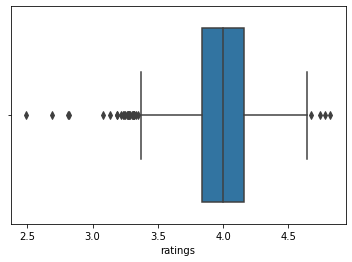

In [76]:
sns.boxplot(df.ratings)

In [79]:
df[df.ratings == 2.490]

,titles,authors,ratings,num_ratings,id,description,pages,genre
1300,One Night at the Call Center,Stephenie Meyer,2.490,50995,105578,Press 1 for technical support. Press 2 for bro...,320.000,"'Cultural', 'Fiction', 'Indian Literature', 'A..."


In [77]:
df.ratings.describe()

count   2193.000
mean       3.988
std        0.246
min        2.490
25%        3.840
50%        4.000
75%        4.160
max        4.820
Name: ratings, dtype: float64

In [30]:
df.isna().sum()

titles         0
authors        0
ratings        0
num_ratings    0
id             0
description    0
pages          0
genre          0
dtype: int64

In [31]:
df.genre1.apply(lambda x: str(x))

AttributeError: 'DataFrame' object has no attribute 'genre1'

In [ ]:
df.genre1.value_counts()

# Recommender System

In [32]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(dff['description'])
tfidf_matrix.shape

(4183, 341700)

In [33]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim[0]

array([1.        , 0.01508352, 0.00822863, ..., 0.00582166, 0.00650778,
       0.00481279])

In [34]:
dff.reset_index(inplace=True)
titles = dff['titles']
indices = pd.Series(dff.index, index=dff['titles'])

In [35]:
indices

titles
Harry Potter and the Prisoner of Azkaban (Harry Potter, #3)                                        0
The Perks of Being a Wallflower                                                                    1
A Walk to Remember                                                                                 2
The Bad Beginning (A Series of Unfortunate Events, #1)                                             3
Interpreter of Maladies                                                                            4
The Reptile Room (A Series of Unfortunate Events, #2)                                              5
Timeline                                                                                           6
Ender's Shadow (The Shadow Series, #1)                                                             7
Invisible Monsters                                                                                 8
Gardens of the Moon (Malazan Book of the Fallen, #1)                                

In [36]:
 def get_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [37]:
get_recommendations('Just Kids')

3347                                              M Train
2302                            Chelsea Chelsea Bang Bang
1835                                    Half Broke Horses
2590                    Lies That Chelsea Handler Told Me
1629               Are You There, Vodka? It's Me, Chelsea
3849                                        The Chalk Man
858                                       The Field Guide
948                                   Out Stealing Horses
1634                     Born Standing Up: A Comic's Life
53                      'Tis A Memoir (Frank McCourt, #2)
2189          The Picture of Dorian Gray: A Graphic Novel
3297    The War That Saved My Life (The War That Saved...
4010                                       My Lovely Wife
3065                                  Brown Girl Dreaming
3125                          The Geography of You and Me
1141                               The Wrath of Mulgarath
1363        Killing Yourself to Live: 85% of a True Story
576           

# NLP Recommender

In [38]:
dff.authors = dff.authors.apply(lambda x: x.split(' '))
dff.authors = dff.authors.apply(lambda x: ''.join(x).lower().replace('.',''))

In [39]:
# dff.genre = dff.genre.apply(lambda x: ''.join(x.split(',')).lower())

In [40]:
dff.genre = dff.genre.apply(lambda x: x.replace(' ','').lower().split(','))

In [41]:
dff.description

0       Harry Potter's third year at Hogwarts is full ...
1       Now in a special edition to mark the twentieth...
2       There was a time when the world was sweeter......
3       Dear Reader,  I'm sorry to say that the book y...
4       Navigating between the Indian traditions they'...
5       Dear Reader,  If you have picked up this book ...
6       In an Arizona desert, a man wanders in a daze,...
7       Welcome to Battleschool.  Growing up is never ...
8       She's a catwalk model who has everything: a bo...
9       The Malazan Empire simmers with discontent, bl...
10                                                       
11      There are six things very wrong with my life: ...
12      The international bestseller that inspired a m...
13      A family with an ancient curse...  And the gir...
14      Nine-year-old Trisha McFarland strays from the...
15      Naruto is a ninja-in-training with an incorrig...
16      Cryptonomicon zooms all over the world, careen...
17      "With 

In [42]:
import string
for c in string.punctuation:
    dff.description = dff.description.apply(lambda x: x.replace(c,""))
    
for s in string.digits:
    dff.description = dff.description.apply(lambda x: x.replace(s,""))
    
dff.description = dff.description.apply(lambda x: x.replace('”',''))
dff.description = dff.description.apply(lambda x: x.replace('“',''))

In [43]:
dff['Key_words'] = ''

for index, row in dff.iterrows():
    plot = row['description']
    
    # instantiating Rake, by default is uses english stopwords from NLTK
    # and discard all puntuation characters
    r = Rake()

    # extracting the words by passing the text
    r.extract_keywords_from_text(plot)

    # getting the dictionary with key words and their scores
    key_words_dict_scores = r.get_word_degrees()
#     print(key_words_dict_scores)
    # assigning the key words to the new column
    dff['Key_words'][index] = list(key_words_dict_scores.keys())
    

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [44]:
dff[['authors','genre','Key_words']]

,authors,genre,Key_words
0,jkrowling,"[middlegrade, adventure, fantasy, audiobook, c...","[hunting, sirius, father, yet, despite, threat..."
1,stephenchbosky,"[fiction, contemporary, youngadult]","[high, school, funny, touching, beloved, cult,..."
2,nicholassparks,"[romance, chicklit, contemporary, fiction, you...","[leading, author, bottle, beaufort, north, car..."
3,lemonysnicket,"[youngadult, childrens, fantasy, fiction]","[unpleasant, tales, putting, say, clever, sort..."
4,jhumpalahiri,"[shortstories, cultural, fiction, india]","[generations, ancestors, navigating, interpret..."
5,lemonysnicket,"[youngadult, childrens, fantasy, fiction]","[company, book, back, hope, appearance, pages,..."
6,michaelcrichton,"[historicalfiction, thriller, sciencefiction, ...","[shocking, discovery, dead, awakened, living, ..."
7,orsonscottcard,"[youngadult, sciencefiction, fiction, fantasy]","[final, climactic, battle, buggers, earth, fut..."
8,chuckpalahniuk,"[mystery, contemporary, thriller, fiction]","[one, search, disfigured, invisible, monster, ..."
9,stevenerikson,"[highfantasy, epicfantasy, fantasy, fiction]","[gathering, formidable, anomander, rake, siege..."


In [47]:
dff.to_csv('df_with_keywords.csv')

In [46]:
dff['bag_of_words'] = ''
columns = dff[['authors','genre','Key_words']]
for index, row in dff.iterrows():
    words = ''
    for col in columns:
        if col != 'authors':
            words = words + ' '.join(row[col])+ ' '
        else:
            words = words + row[col]+ ' '
    dff['bag_of_words'][index] = words
    
# dff.drop(columns = [col for col in dff.columns if col!= 'bag_of_words'], inplace = True)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [48]:
df_final = dff[['titles','bag_of_words']]

In [49]:
df_final.set_index('titles',inplace=True)

## Vectorize

In [51]:
# instantiating and generating the count matrix
count = CountVectorizer()
count_matrix = count.fit_transform(df_final['bag_of_words'])

In [54]:
# creating a Series for the movie titles so they are associated to an ordered numerical
# list I will use later to match the indexes
indices = pd.Series(df_final.index)

In [56]:
# generating the cosine similarity matrix
cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [70]:
# helper functions for interfacing with the recommendation system

def fail_to_find(df):
    final = input("That title did not match any of our books! Please try again, or enter 'quit!' to stop playing.")
    if final == 'quit!':
        return 0
    else:
        return find_title(final, df)
        
def find_title(guess, df):
    guess = guess.lower()
    final = []
    titles_list = {x.lower(): x for x in df.index}
    for possible in list(titles_list.keys()):
        if guess in possible:
               final.append(possible)
    if len(final) == 0:
        return fail_to_find(df)
    if len(final) == 1:
        print (f"\n Great! Looking for recomendations for the book: {titles_list[final[0]]}")
        return titles_list[final[0]]
    elif len(final) > 1:
        maybe = input(f"We found {len(final)} books that matched your search! Would you like to look thru them? If so enter 'yes', otherwise enter 'no'.")
        if maybe == 'yes':
            print ("Is your book in this list? \n")
            maybe = input(f"{final}\n")
        for poss in final:
            end = input(f"Is your book {titles_list[poss]}? If so enter 'yes' and if not enter 'no'.")
            if end == 'yes':
                print (f"\n Great! Looking for recomendations for the book: {titles_list[poss]}")
                return titles_list[poss]
        return fail_to_find(df)
        

In [123]:
def recommendations(title, list_length=11, df=df_final, cosine_sim = cosine_sim, suppress=False):
    
    recommended_books = []
    
    title = find_title(title, df)
    if title == 0:
        print ('Try again later')
        return 0
    
    # gettin the index of the book that matches the title
    idx = indices[indices == title].index[0]

    # creating a Series with the similarity scores in descending order
    score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)

    # getting the indexes of the 10 most similar movies
    top_10_indexes = list(score_series.iloc[1:list_length+1].index)
    
    # populating the list with the titles of the best 10 matching movies
    for i in top_10_indexes:
        recommended_books.append(list(df.index)[i])
    
    if suppress == False:
        print (f"\n We recommend \n {recommended_books}")
    return recommended_books

In [156]:
recommendations('bossypants')


 Great! Looking for recomendations for the book: Bossypants

 We recommend 
 ['Is Everyone Hanging Out Without Me?', 'My Life on the Road', 'Truth and Beauty', 'Brain on Fire: My Month of Madness', 'Wild: From Lost to Found on the Pacific Crest Trail', 'Sickened: The Memoir of a Munchausen by Proxy Childhood', 'Wishful Drinking', 'Life', 'Kitchen Confidential: Adventures in the Culinary Underbelly', 'Tweak: Growing Up On Methamphetamines', "Seriously... I'm Kidding"]


['Is Everyone Hanging Out Without Me?',
 'My Life on the Road',
 'Truth and Beauty',
 'Brain on Fire: My Month of Madness',
 'Wild: From Lost to Found on the Pacific Crest Trail',
 'Sickened: The Memoir of a Munchausen by Proxy Childhood',
 'Wishful Drinking',
 'Life',
 'Kitchen Confidential: Adventures in the Culinary Underbelly',
 'Tweak: Growing Up On Methamphetamines',
 "Seriously... I'm Kidding"]

In [124]:
df_filter = dff[['titles','bag_of_words','num_ratings','pages','ratings']].copy(deep=False)
df_filter.set_index('titles', inplace=True)

In [157]:
df_filter

,bag_of_words,num_ratings,pages,ratings
titles,,,,
"Harry Potter and the Prisoner of Azkaban (Harry Potter, #3)",jkrowling middlegrade adventure fantasy audiob...,2435849,435.000,4.560
The Perks of Being a Wallflower,stephenchbosky fiction contemporary youngadult...,1138861,224.000,4.200
A Walk to Remember,nicholassparks romance chicklit contemporary f...,617830,215.000,4.170
"The Bad Beginning (A Series of Unfortunate Events, #1)",lemonysnicket youngadult childrens fantasy fic...,357436,176.000,3.930
Interpreter of Maladies,jhumpalahiri shortstories cultural fiction ind...,149557,198.000,4.140
"The Reptile Room (A Series of Unfortunate Events, #2)",lemonysnicket youngadult childrens fantasy fic...,167958,192.000,3.980
Timeline,michaelcrichton historicalfiction thriller sci...,177986,489.000,3.850
"Ender's Shadow (The Shadow Series, #1)",orsonscottcard youngadult sciencefiction ficti...,143282,469.000,4.310
Invisible Monsters,chuckpalahniuk mystery contemporary thriller f...,117223,304.000,4.000


In [126]:
def return_len_df(legnth, df):
    
    return df_len

def return_pop_df(popularity, df):
    return df_pop



In [ ]:
def rec_w_filter(title,length=None, popularity=None): 
    
#     title = find_title(title, df_filter)
    
    indices = pd.Series(df_.index)
    idx = indices[indices == title].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:100]
    movie_indices = [i[0] for i in sim_scores]
    
    books = df_filter.iloc[movie_indices]
    pages = books['pages'].astype('int')
    short_books = books[(books['pages'] < 350)]
    short_low_books = books[(books['pages'] < 350)][(books['num_ratings'] < 27000)]
    short_medium_books = books[(books['pages'] < 350)][(books['num_ratings'] < 80000) & (books['num_ratings'] > 27000)]
    short_high_books = books[(books['pages'] < 350)][(books['num_ratings'] > 80000)]
    
    long_books = books[(books['pages'] >= 350)]
    long_low_books = books[(books['pages'] >= 350)][(books['num_ratings'] < 27000)]
    long_medium_books = books[(books['pages'] >= 350)][(books['num_ratings'] < 80000) & (books['num_ratings'] > 27000)]
    long_high_books = books[(books['pages'] >= 350)][(books['num_ratings'] > 80000)]
    
    if length == 'short' and popularity == 'low':
        return list(short_low_books.index)[:11]
    elif length == 'short' and popularity == 'medium' :
        return list(short_medium_books.index)[:11]
    elif length == 'short' and popularity == 'high':
        return list(short_high_books.index)[:11]
    elif length == 'long' and popularity == 'low':
        return list(long_low_books.index)[:11]
    elif length == 'long' and popularity == 'medium':
        return list(long_medium_books.index)[:11]
    elif length == 'long' and popularity == 'high':
        return list(long_high_books.index)[:11]
    

In [189]:
df_final[:11]

,bag_of_words
titles,
"Harry Potter and the Prisoner of Azkaban (Harry Potter, #3)",jkrowling middlegrade adventure fantasy audiob...
The Perks of Being a Wallflower,stephenchbosky fiction contemporary youngadult...
A Walk to Remember,nicholassparks romance chicklit contemporary f...
"The Bad Beginning (A Series of Unfortunate Events, #1)",lemonysnicket youngadult childrens fantasy fic...
Interpreter of Maladies,jhumpalahiri shortstories cultural fiction ind...
"The Reptile Room (A Series of Unfortunate Events, #2)",lemonysnicket youngadult childrens fantasy fic...
Timeline,michaelcrichton historicalfiction thriller sci...
"Ender's Shadow (The Shadow Series, #1)",orsonscottcard youngadult sciencefiction ficti...
Invisible Monsters,chuckpalahniuk mystery contemporary thriller f...


In [229]:
def rec_w_filter(title,length=None, popularity=None, df_filter=df_filter): 

    title = find_title(title, df_filter)
    
    indices = pd.Series(df_filter.index)
    idx = indices[indices == title].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:100] # because the book selected willl be most similar
    movie_indices = [i[0] for i in sim_scores]
    df = df_filter.iloc[movie_indices]
     
    return filter_df(length, popularity, df)

In [181]:
import warnings
warnings.filterwarnings("ignore")

In [230]:
rec_w_filter('sapiens',length='long',popularity='well known')

We found 2 books that matched your search! Would you like to look thru them? If so enter 'yes', otherwise enter 'no'.sapiens
Is your book Sapiens: A Brief History of Humankind? If so enter 'yes' and if not enter 'no'.yes

 Great! Looking for recomendations for the book: Sapiens: A Brief History of Humankind


,bag_of_words,num_ratings,pages,ratings
titles,,,,
21 Lessons for the 21st Century,yuvalnoahharari politics science nonfiction hi...,46183,372.000,4.190
The Undoing Project: A Friendship That Changed Our Minds,jessieburton biography science economics nonfi...,37846,368.000,3.980
1491: New Revelations of the Americas Before Columbus,charlescmann history northamericanhi... anthro...,57303,541.000,4.020
Salt: A World History,(writer) history science food foodanddrink non...,50862,484.000,3.740
"Opposition (Lux, #5)",ianmcewan aliens youngadult romance paranormal...,57977,533.000,4.410
Collapse: How Societies Choose to Fail or Succeed,jennifercrusie history anthropology science so...,54988,608.000,3.930
Thunderstruck,immaculéeilibagiza history science crime truec...,34161,463.000,3.700
Musicophilia: Tales of Music and the Brain,oliversacks psychology science music biology n...,51108,400.000,3.910
History of Beauty,chelseahandler history arthistory philosophy n...,47113,432.000,3.770


In [186]:
df_filter[df_filter['num_ratings'] < 27000]

,bag_of_words,num_ratings,pages,ratings
titles,,,,
Genome: the Autobiography of a Species in 23 Chapters,mattridley evolution science biology genetics ...,22229,344.000,4.030
"Galileo's Daughter: A Historical Memoir of Science, Faith and Love",davasobel history nonfiction biography science...,25461,420.000,3.760
How to Talk to Anyone: 92 Little Tricks for Big Success in Relationships,jonathanlethem psychology selfhelp language co...,17769,345.000,3.780
The Code Book: The Science of Secrecy from Ancient Egypt to Quantum Cryptography,patriciacornwell nonfiction history mathematic...,19231,412.000,4.300
Stolen Lives: Twenty Years in a Desert Jail,simonsingh nonfiction autobiography memoir bio...,26923,294.000,4.100
The Wedding Girl,adelineyenmah chicklit womensfiction fiction r...,26673,320.000,3.490
Nonviolent Communication: A Language of Life,lancearmstrong psychology selfhelp language co...,14219,220.000,4.340
Ghostwritten,marshallbrosenberg fantasy contemporary scienc...,24867,426.000,4.050
Brief Interviews with Hideous Men,davidmitchell shortstories contemporary fictio...,22904,273.000,3.860


In [188]:
df_filter[(df_filter['num_ratings'] < 80000) & (df_filter['num_ratings'] > 27000)]

,bag_of_words,num_ratings,pages,ratings
titles,,,,
In the Heart of the Sea: The Tragedy of the Whaleship Essex,nathanielphilbrick history survival adventure ...,75810,302.000,4.160
"Hannibal (Hannibal Lecter, #3)",thomasharris thriller horror crime fiction mys...,77586,564.000,3.760
Disgrace,jmcoetzee southernafrica novels cultural ficti...,76658,220.000,3.840
Hearts in Atlantis,stephenking horror fiction fantasy war adults ...,79884,640.000,3.820
Keeping Faith,jodipicoult drama chicklit contemporary fictio...,75597,422.000,3.800
Battle Royale,koushuntakami thriller horror sciencefiction d...,49586,617.000,4.230
"Daughter of the Forest (Sevenwaters, #1)",julietmarillier historicalfiction fantasy roma...,51021,554.000,4.270
"Beyond the Highland Mist (Highlander, #1)",karenmariemoning historicalfiction adult fanta...,61911,375.000,3.980
Keeping the Moon,sarahdessen fiction contemporary youngadult ro...,59156,228.000,3.860


In [228]:
def return_pop_df(popularity, df=df_filter):
    if popularity == 'deep cut':
        return df[df['num_ratings'] < 27000]
    if popularity == 'well known':
        return df[(df['num_ratings'] < 80000) & (df['num_ratings'] > 27000)]
    if popularity == 'super popular':
        return df[df['num_ratings'] > 80000]
    
def filter_df(length, popularity, df):
    if length != None:
        if length == 'long':
            df = df[(df['pages'] >= 350)]
        elif length == 'short':
            df = df[(df['pages'] < 350)]
        
    if popularity != None:
        df = return_pop_df(popularity, df)
    
    if len(df) > 10:
        return df[:11]
    else:
        return df
    

In [218]:
df_filter

,bag_of_words,num_ratings,pages,ratings
titles,,,,
"Harry Potter and the Prisoner of Azkaban (Harry Potter, #3)",jkrowling middlegrade adventure fantasy audiob...,2435849,435.000,4.560
The Perks of Being a Wallflower,stephenchbosky fiction contemporary youngadult...,1138861,224.000,4.200
A Walk to Remember,nicholassparks romance chicklit contemporary f...,617830,215.000,4.170
"The Bad Beginning (A Series of Unfortunate Events, #1)",lemonysnicket youngadult childrens fantasy fic...,357436,176.000,3.930
Interpreter of Maladies,jhumpalahiri shortstories cultural fiction ind...,149557,198.000,4.140
"The Reptile Room (A Series of Unfortunate Events, #2)",lemonysnicket youngadult childrens fantasy fic...,167958,192.000,3.980
Timeline,michaelcrichton historicalfiction thriller sci...,177986,489.000,3.850
"Ender's Shadow (The Shadow Series, #1)",orsonscottcard youngadult sciencefiction ficti...,143282,469.000,4.310
Invisible Monsters,chuckpalahniuk mystery contemporary thriller f...,117223,304.000,4.000


In [220]:
df_final.head()

,bag_of_words
titles,
"Harry Potter and the Prisoner of Azkaban (Harry Potter, #3)",jkrowling middlegrade adventure fantasy audiob...
The Perks of Being a Wallflower,stephenchbosky fiction contemporary youngadult...
A Walk to Remember,nicholassparks romance chicklit contemporary f...
"The Bad Beginning (A Series of Unfortunate Events, #1)",lemonysnicket youngadult childrens fantasy fic...
Interpreter of Maladies,jhumpalahiri shortstories cultural fiction ind...


In [ ]:
#create new dataframe for Simple Recommender
df_simple = pd.concat([df,df1])
df_simple.genre = df_simple.genre.apply(lambda x: x.replace("'",''))
df_simple.reset_index(inplace=True)
df_simple.drop('index',axis=1,inplace=True)

#dataframe with genre and titles as index
df_genre = df_simple[['genre','titles']].set_index('titles')

#make df_genre into dictionary
genre_dict = dict(df_genre.genre)

#put sub-genres into main genres dictionary
genre_id_dict = {'Scifi': [], 'Romance':[], 'Thriller':[], 'Comics':[], 'Biography':[], 'Nonfiction':[], 'Self_help':[], 'Young_Adult':[], 'Family':[], 'Fiction':[]}
for k,v in genre_dict.items():
    if ('Fantasy' in v) or ('Science' in v):
        genre_id_dict['Scifi'].append(k)
    if ('Romance' in v) or ('Chick Lit' in v) or ('Erotic' in v) or ('Contemporary' in v) or ('Drama' in v):
        genre_id_dict['Romance'].append(k)
    if ('Thriller' in v) or ('Mystery' in v) or ('Crime' in v) or ('Horror' in v):
        genre_id_dict['Thriller'].append(k)
    if ('Comic' in v) or ('Graphic' in v) or ('Manga' in v):
        genre_id_dict['Comics'].append(k)
    if ('Biography' in v) or ('Autobiography' in v) or ('Memoir' in v) or ('Sport' in v):
        genre_id_dict['Biography'].append(k)
    if ('Nonfiction' in v) or ('History' in v) or ('Politics' in v) or ('Cooking' in v) or ('Art' in v):
        genre_id_dict['Nonfiction'].append(k)
    if ('Self Help' in v) or ('Religion' in v):
        genre_id_dict['Self_help'].append(k)
    if ('Young Adult' in v):
        genre_id_dict['Young_Adult'].append(k)
    if ('Childrens' in v) or ('Family' in v):
        genre_id_dict['Family'].append(k)
    if ('Fiction' in v):
        genre_id_dict['Fiction'].append(k)
        
def simple_rec(dict, df, genre, length, popularity):
    poss_books = dict[genre]
    df = df.iloc[poss_books]
    
    return filter_df(length, popularity, df)
    
